In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import ConcatDataset
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import datasets

# Load the  dataset without normalization
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)

# Calculate mean and std across the dataset
data = train_dataset.data/ 255.  # Scale pixel values to [0, 1]
mean = torch.mean(data)
std= torch.std(data)

print("Mean:", mean)
print("Std Deviation:", std)

100%|██████████| 26421880/26421880 [00:03<00:00, 8518787.22it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 66234.19it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 499460.34it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18940593.85it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Mean: tensor(0.2860)
Std Deviation: tensor(0.3530)


In [3]:

# Load the MNIST dataset without normalization
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

# Calculate mean and std across the dataset
data = test_dataset.data/ 255.  # Scale pixel values to [0, 1]
mean = torch.mean(data)
std= torch.std(data)

print("Mean:", mean)
print("Std Deviation:", std)

Mean: tensor(0.2868)
Std Deviation: tensor(0.3524)


In [4]:
import torch
from torchvision import datasets, transforms

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    # Add other transformations as needed (resize, normalization, etc.)
])

# Load the datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Combine both datasets
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# Collect all tensors into a list
tensor_list = []
for i in range(len(combined_dataset)):
    tensor_list.append(combined_dataset[i][0])  # Assuming the first element of each sample is the tensor/image

# Stack the tensors into a single tensor
combined_tensor = torch.stack(tensor_list)

# Check the type and shape of the combined tensor
print(type(combined_tensor))
print(combined_tensor.shape)


<class 'torch.Tensor'>
torch.Size([70000, 1, 28, 28])


In [5]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=10):
        super(Net, self).__init__()

        # Our images are grayscale, so input channels = 1. We'll apply 48 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=2, stride=1, padding=1)

        # We'll apply max pooling with a kernel size of 2
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # A second convolutional layer takes 48 input channels, and generates 96 outputs
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=2, stride=1, padding=1)

        # We'll apply another max pooling with a kernel size of 2
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # A drop layer deletes 30% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.3)

        # Our 28x28 image tensors will be pooled twice with a kernel size of 2. 28/2/2 is 7.
        # So our feature tensors are now 7 x 7, and we've generated 96 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=7 * 7 * 96, out_features=164)
        self.fc2 = nn.Linear(in_features=164, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool1(self.conv1(x)))

        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool2(self.conv2(x)))

        # Select some features to drop after the 2nd convolution to prevent overfitting
        x = self.drop(x)

        # Flatten
        x = x.view(-1, 7 * 7 * 96)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        x = self.fc2(x)
        # Return log_softmax tensor
        return F.log_softmax(x, dim=1)
# Instantiate the model
model = Net()
print("CNN model class defined!")

CNN model class defined!


In [6]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print(f'Training set:{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader)} Loss:{loss.item()})')
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [7]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    accuracy = correct / len(val_indices)  # Using the length of the validation subset loader
    print(f'Validation set: Average loss: {avg_loss}, Accuracy: {correct}/{len(val_indices)} ({100. * accuracy}%)')
   # return average loss for the epoch
    return avg_loss

In [8]:
from sklearn.model_selection import KFold

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print('Training on', device)

# Define k value for k-fold cross-validation
k = 7  # You can set the desired number of folds

# Initialize k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
batch_size = 64
epoch_nums = []
training_loss = []
validation_loss = []
fold_accuracies = []  # Track accuracy for each fold
test_losses = []

for fold, (train_indices, val_indices) in enumerate(kf.split(combined_tensor)):
    print(f"Fold {fold + 1}/{k}")

    # Create data loaders for this fold
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    fold_train_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size, sampler=train_sampler)
    fold_val_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size, sampler=val_sampler)

    # Reinitialize model for each fold
    model = Net(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 10

    # Track accuracy for this fold
    correct = 0
    total = 0

    # Train the model for this fold
    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, fold_train_loader, optimizer, epoch)
        val_loss = test(model, device, fold_val_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)

    # Calculate accuracy for this fold
    with torch.no_grad():
        for data, target in fold_val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    fold_accuracy = 100 * correct / total
    fold_accuracies.append(fold_accuracy)
    print(f"Accuracy for fold {fold + 1}: {fold_accuracy:.2f}%")

# Calculate average accuracy across all folds
avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"Average accuracy across all folds: {avg_accuracy:.2f}%")


Streaming output truncated to the last 5000 lines.
Training set:35200/70000 (58.63539445628998 Loss:0.19694341719150543)
Training set:35840/70000 (59.701492537313435 Loss:0.16531775891780853)
Training set:36480/70000 (60.76759061833689 Loss:0.20398035645484924)
Training set:37120/70000 (61.833688699360344 Loss:0.22785986959934235)
Training set:37760/70000 (62.89978678038379 Loss:0.2663370370864868)
Training set:38400/70000 (63.96588486140725 Loss:0.16028150916099548)
Training set:39040/70000 (65.0319829424307 Loss:0.17300555109977722)
Training set:39680/70000 (66.09808102345416 Loss:0.22443245351314545)
Training set:40320/70000 (67.16417910447761 Loss:0.25465911626815796)
Training set:40960/70000 (68.23027718550107 Loss:0.18372970819473267)
Training set:41600/70000 (69.29637526652452 Loss:0.18687567114830017)
Training set:42240/70000 (70.36247334754798 Loss:0.21477815508842468)
Training set:42880/70000 (71.42857142857143 Loss:0.2985050678253174)
Training set:43520/70000 (72.49466950959

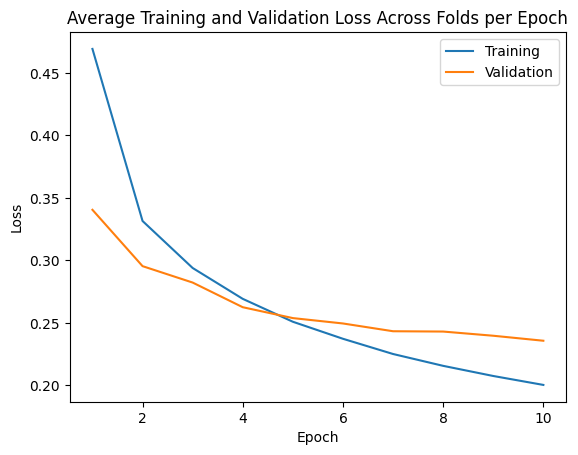

In [9]:
from matplotlib import pyplot as plt

# Initialize lists to store average losses
avg_training_loss = []
avg_validation_loss = []

# Iterate through epochs
for epoch in range(1, epochs + 1):
    # Initialize variables to accumulate losses for the current epoch
    epoch_training_losses = []
    epoch_validation_losses = []

    # Iterate through folds
    for fold in range(k):
        # Filter losses for the current epoch and fold
        epoch_fold_training_losses = [training_loss[i] for i in range(len(epoch_nums)) if epoch_nums[i] == epoch and i % k == fold]
        epoch_fold_validation_losses = [validation_loss[i] for i in range(len(epoch_nums)) if epoch_nums[i] == epoch and i % k == fold]

        # Aggregate losses for the current fold
        epoch_training_losses.extend(epoch_fold_training_losses)
        epoch_validation_losses.extend(epoch_fold_validation_losses)

    # Calculate average losses for the current epoch and append to lists
    avg_training_loss.append(sum(epoch_training_losses) / len(epoch_training_losses))
    avg_validation_loss.append(sum(epoch_validation_losses) / len(epoch_validation_losses))

# Plot average training and validation loss across all folds per epoch
plt.plot(range(1, epochs + 1), avg_training_loss, label='Training')
plt.plot(range(1, epochs + 1), avg_validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Average Training and Validation Loss Across Folds per Epoch')
plt.show()
